In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
from tqdm import trange

from bayes_module import Bayes_1d
from animation import create_animation_1d

地震動の場合、解析解が複雑になってしまうので正弦波で解析を行う

- 正弦波の場合の解析解を求めて、地震動とその変位のデータを作成する
- 尤度関数は適当な正規分布を当てはめて、ベイズ推定をしてみる
- 問題となるのは事前分布のkde（そもそも離散化したままで良い？サンプル数を増やす？）
- 1つに定まらないので、確率的にどのセットが破損している確率が高いかが示せれば良い
- その後の課題として同時に壊れやすいところを共分散をいじることで（指定するのは相関係数）表現する
- ダンパを入れた時にどうなるのか
- 3自由度にするとどうなるのか
- 徐々に壊れていくものを検知できるか

# 1自由度バネマス系

In [2]:
# 微分方程式を離散化
delta = 1e-2
delta2 = delta**2
time_range = 10.0
steps = int(time_range/delta)
x = np.linspace(0.0, time_range, steps)
m = 1e5
k = 4e7
x_pre, x_cur = 0.0, 0.0
x_his = [x_cur]
# 一層目(地面)の加速度：地震の加速度*(-1)
amp = 1  # 振幅
ground_acc = amp * np.sin(np.pi*x)

for i in trange(steps):
    x_next = -x_cur/m*delta2*k + 2*x_cur - x_pre - ground_acc[i]*delta2
    x_his.append(x_next)
    x_pre, x_cur = x_cur, x_next

100%|██████████| 1000/1000 [00:00<00:00, 113997.34it/s]


In [3]:
# 理論解
w = np.sqrt(k/m)
theoretical_dis = +np.pi/(w*(w**2-np.pi**2))*np.sin(w*x) - 1/(w**2-np.pi**2)*np.sin(np.pi*x)

In [4]:
# RESPの計算結果
resp_dis = pd.read_csv('output_resp/single_Dis.csv')['N002:DIS:UX']

In [5]:
dis = pd.read_csv('output_resp/single_Dis.csv')['N002:DIS:UX']
acc = pd.read_csv('output_resp/single_ACC.csv')['N001:ACC:UX']

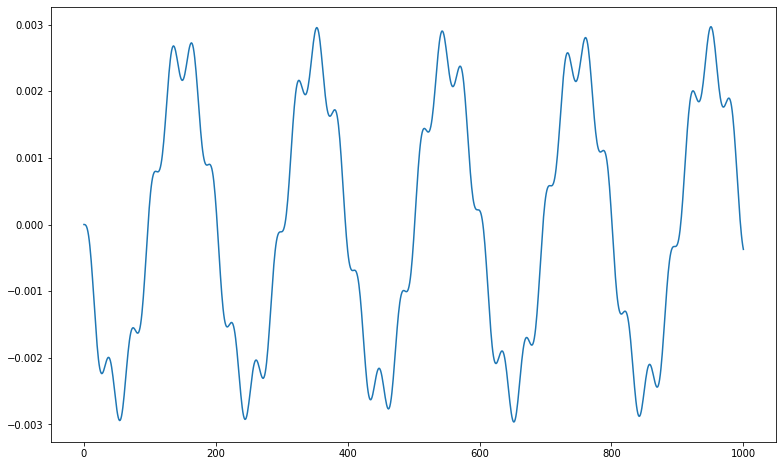

In [6]:
plt.figure(figsize=[13,8])
plt.plot(dis)

### 比較

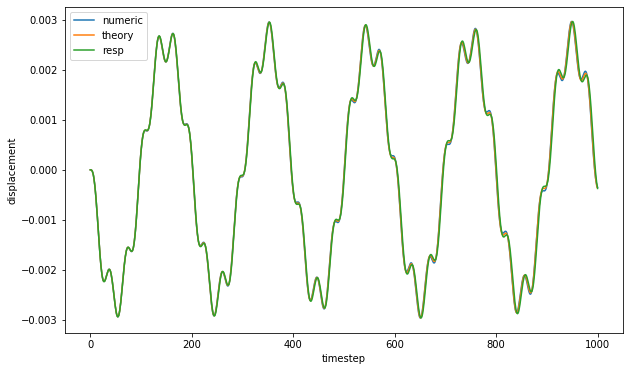

In [7]:
plt.figure(figsize=[10, 6])
plt.plot(x_his, label='numeric')
plt.plot(theoretical_dis, label='theory')
plt.plot(resp_dis, label='resp')
plt.xlabel('timestep')
plt.ylabel('displacement')
plt.legend()

数値計算と理論解とRESP計算が一致することが確認できた

## ベイズ推定 ~1自由度~

In [8]:
k_senarios_1d = [1e7, 2e7, 3e7, 4e7, 5e7, 6e7, 7e7]
acc_end = pd.read_csv('output_resp/single_ACC.csv')['N001:ACC:UX']

1001it [00:01, 869.76it/s]


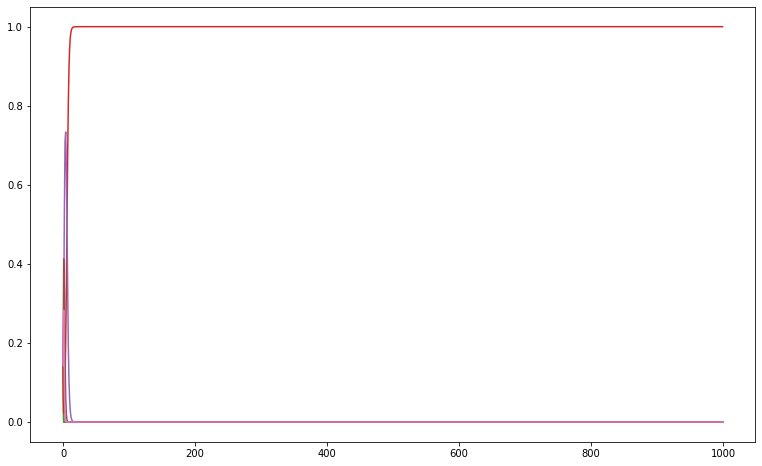

In [9]:
bayes_1d = Bayes_1d(k_senarios_1d, acc_end, resp_dis)
bayes_1d.infer()  # 逐次推定する
plt.figure(figsize=[13,8])
plt.plot(bayes_1d.dist_his)

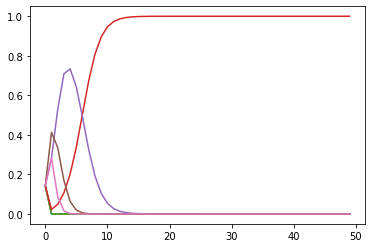

In [10]:
plt.plot(bayes_1d.dist_his[:50])

In [11]:
phase_qty = 800
infer_counts_1d = bayes_1d.infer_counts(phase_qty, 3)

100%|██████████| 800/800 [00:09<00:00, 88.02it/s]


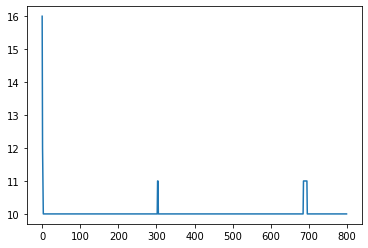

In [12]:
plt.plot(infer_counts_1d)

1自由度において上手く推定できることが確認できた

変位が0に近いときは分散も0に近くなるので推定結果がほとんど変化しないことは面白い

分布の推移をアニメーションで表現する

In [13]:
# bayes_1d_from_middle = Bayes_1d(k_senarios_1d, acc_end[100:], resp_dis[100:])
# bayes_1d_from_middle.infer()  # 逐次推定する
# create_animation_1d(k_senarios_1d, bayes_1d_from_middle.dist_his[:15], '1d_from_middle')